# ORIE 4741 - Exploring Wine

In [25]:
import pandas as pd
import numpy as np
import scipy.stats as scipy
import scipy.linalg
import matplotlib.pyplot as py
import random
%matplotlib inline
from pandas import read_csv

In [26]:
df = pd.read_json('/Users/alexanderdowney/Downloads/winemag-data_first150k.json')

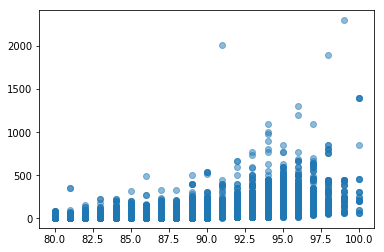

In [27]:
py.scatter(df['points'],df['price'],alpha=0.5)
py.show()
size_of_dataset=[]
size_of_dataset.append(len(df))

In [28]:
df_store=df
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,None,Provence red blend,Domaine de la Bégude
5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,None,Tinta de Toro,Numanthia
6,Spain,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Toro,None,Tinta de Toro,Maurodos
7,Spain,Lush cedary black-fruit aromas are luxe and of...,Carodorum Único Crianza,95,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


In [29]:
countries = df['country'].unique()
country_count=[]
countries_kept = []
for i in range(0,len(countries)):
    country_count.append(len(df.loc[df['country'] == countries[i]]))
    print(countries[i],len(df.loc[df['country'] == countries[i]]))
for j in range(0,len(countries)):
    if country_count[j]>500:
        countries_kept.append(countries[j])
df = df[df['country'].isin(countries_kept)]
size_of_dataset.append(len(df))

US 62397
Spain 8268
France 21098
Italy 23478
New Zealand 3320
Bulgaria 77
Argentina 5631
Australia 4957
Portugal 5322
Israel 630
South Africa 2258
Greece 884
Chile 5816
Morocco 12
Romania 139
Germany 2452
Canada 196
Moldova 71
Hungary 231
Austria 3057
Croatia 89
Slovenia 94
None 0
India 8
Turkey 52
Macedonia 16
Lebanon 37
Serbia 14
Uruguay 92
Switzerland 4
Albania 2
Bosnia and Herzegovina 4
Brazil 25
Cyprus 31
Lithuania 8
Japan 2
China 3
South Korea 4
Ukraine 5
England 9
Mexico 63
Georgia 43
Montenegro 2
Luxembourg 9
Slovakia 3
Czech Republic 6
Egypt 3
Tunisia 2
US-France 1


In [23]:
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,None,Provence red blend,Domaine de la Bégude
5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,None,Tinta de Toro,Numanthia
6,Spain,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Toro,None,Tinta de Toro,Maurodos
7,Spain,Lush cedary black-fruit aromas are luxe and of...,Carodorum Único Crianza,95,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm
